In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.colors as colors
import matplotlib as mpl
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import cartopy.feature as cfeature 
import cartopy.mpl.ticker as cticker 
import imageio
import os
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance, plot_tree

# Read the Argo and OISST data (1/16 deg spatial resolution)

In [2]:
Argo = xr.open_dataset(r"C:\Users\lv299\OneDrive\STF_Paper\Subtropical-Front-Modeling-Code\Step1\Argo_Merge_Cut_1_16Deg\argo_1_16_deg.nc")
oisst = xr.open_dataset(r"C:\Users\lv299\OneDrive\STF_Paper\Subtropical-Front-Modeling-Code\Step1\OISST_Merge_Cut_1_16Deg_Monthly\oisst_1_16_deg.nc")

In [3]:
oisst

<xarray.Dataset>
Dimensions:  (time: 240, lat: 325, lon: 5757)
Coordinates:
  * time     (time) datetime64[ns] 2004-01-15 2004-02-15 ... 2023-12-15
  * lat      (lat) float64 -50.12 -50.06 -50.0 -49.94 ... -30.0 -29.94 -29.88
  * lon      (lon) float64 0.125 0.1875 0.25 0.3125 ... 359.7 359.8 359.8 359.9
Data variables:
    sst      (time, lat, lon) float64 ...

In [4]:
Argo

<xarray.Dataset>
Dimensions:  (time: 240, lat: 325, lon: 5757)
Coordinates:
  * time     (time) datetime64[ns] 2004-01-15 2004-02-15 ... 2023-12-15
  * lat      (lat) float64 -50.12 -50.06 -50.0 -49.94 ... -30.0 -29.94 -29.88
  * lon      (lon) float64 0.125 0.1875 0.25 0.3125 ... 359.7 359.8 359.8 359.9
Data variables:
    sst      (time, lat, lon) float64 ...

# Build the functions to identify the STF location (100m 11degC)

In [5]:
def stf_indentifier(st100):
    """
    Identify the subtropical front (STF) from Argo 100m sea tempearture data
    by modifying the Orsi et al. (1995) definition (10.7 degT to 11.3 degT at 100m). 

    Parameters:
    -----------
    st100: xarray dataset
        Argo 100m sea temperature data.

    Returns:
    -----------
    stf: xarray dataset
        Subtropical front index data (binary value).
    """

    stf = st100.where((st100['sst'] >= 10.7) & (st100['sst'] <= 11.3), 1)
    stf = stf.where((stf['sst'] != 1), np.nan)
    stf 
    return stf

In [6]:
def stf_indentifier_with_sst(st100, oisst):
    """
    Identify the subtropical front (STF) from Argo 100m sea tempearture data
    by modifying the Orsi et al. (1995) definition (10.7 degT to 11.3 degT at 100m). 

    Parameters:
    -----------
    st100: xarray dataset
        Argo 100m sea temperature data.

    Returns:
    -----------
    sst_stf: xarray dataset
        Sea Surface Temperature above the STF.
    """

    stf_index = st100.where((st100['sst'] >= 10.7) & (st100['sst'] <= 11.3), 0)

    np_stf_index = stf_index.to_array().values

    np_sst = oisst.to_array().values

    np_sst_stf = np.where(np_stf_index, np_sst, np.nan)

    np_sst_stf = np.squeeze(np_sst_stf)
    sst_stf = xr.DataArray(np_sst_stf, coords=[oisst['time'], oisst['lat'], oisst['lon'] ], dims=['time', 'lat', 'lon'])
    return sst_stf    


In [ ]:
def training_testing_split(input_data):
    """
    Parameters: 
    -----------
    input_data: xarray dataset
        Input data (STF_index / SST_STF) for training and testing split.

    Returns:
    -----------
    train_data: xarray dataset
        Training data (Randomly selected 15 years).
    test_data: xarray dataset
        Testing data (Randomly selected 5 years).
    """ 

     


In [7]:
stf_index = stf_indentifier(Argo)


In [8]:
stf_index

<xarray.Dataset>
Dimensions:  (time: 240, lat: 325, lon: 5757)
Coordinates:
  * time     (time) datetime64[ns] 2004-01-15 2004-02-15 ... 2023-12-15
  * lat      (lat) float64 -50.12 -50.06 -50.0 -49.94 ... -30.0 -29.94 -29.88
  * lon      (lon) float64 0.125 0.1875 0.25 0.3125 ... 359.7 359.8 359.8 359.9
Data variables:
    sst      (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

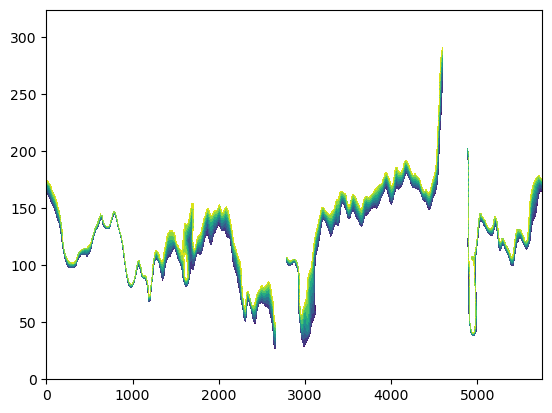

In [9]:
plt.contourf(stf_index.sst[0,:,:])

In [10]:
sst_stf = stf_indentifier_with_sst(Argo, oisst)

In [11]:
sst_stf

<xarray.DataArray (time: 240, lat: 325, lon: 5757)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time     (time) datetime64[ns] 2004-01-15 2004-02-15 ... 2023-12-15
  * lat      (lat) float64 -50.12 -50.06 -50.0 -49.94 ... -30.0 -29.94 -29.88
  * lon      (lon) float64 0.125 0.1875 0.25 0.3125 ... 359.7 359.8 359.8 359.9

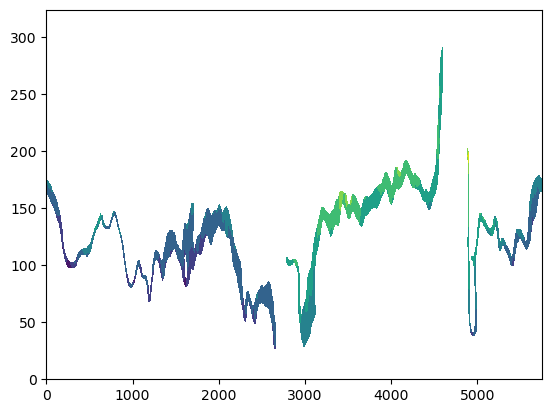

In [12]:
plt.contourf(sst_stf[0,:,:])